In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import random
import time
from tqdm.notebook import tqdm

import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.datasets import GNNBenchmarkDataset
from torch_geometric.data import Data, Batch
from torch_geometric.utils.convert import from_networkx
import networkx as nx
from scipy import sparse as sp

from models import NodeClassificationGraphTransformer, GraphTransformerEdges, GraphTransformer, GraphRepresentationGraphTransformer
from preprocess import AddLaplacianPosEncoding, AddWLPosEncoding, MakeFullGraph
from trainSBM import train_one_epoch, evaluate

In [2]:
SEED = 0

if torch.cuda.is_available():
    print('cuda available with GPU:',torch.cuda.get_device_name(0))
    device = torch.device("cuda")
else:
    print('cuda not available')
    device = torch.device("cpu")

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device.type == 'cuda':
    torch.cuda.manual_seed(SEED)


cuda available with GPU: NVIDIA GeForce GTX 1660 Ti


In [3]:
# Dimension of positional encoding, ex number of non-trivial eigenvalues for laplacian positional encoding
POS_ENCODING_DIM = 2 # 2 / 10

# Training parameters
BATCH_SIZE = 32
INIT_LR = 0.0005
WEIGHT_DECAY = 0.0
LR_REDUCE_FACTOR = 0.5
PATIENCE = 10
MIN_LR = 1e-6
EPOCHS = 50

# Network parameters
n_hidden = 80
n_head = 8
n_feedforward = 160
n_layers = 4
input_dropout = 0.0
dropout = 0.0
norm = 'layer'
readout = 'mean'

In [39]:
transforms = T.Compose([
    AddLaplacianPosEncoding(POS_ENCODING_DIM),
    AddWLPosEncoding(),
    #MakeFullGraph(),
    #T.AddSelfLoops('edge_attr')
])

# Generate a list of 10 cycle graphs with sizes ranging from 10 to 20
networkx_graphs = [nx.cycle_graph(num_nodes) for num_nodes in range(10, 20)]

# Convert NetworkX graphs to PyTorch Geometric format
torch_geometric_graphs = [transforms(from_networkx(graph)) for graph in networkx_graphs]

# Create a batch from the list of graphs
batch = Batch.from_data_list(torch_geometric_graphs)
batch

DataBatch(edge_index=[2, 290], num_nodes=145, laplacian_eigs=[145, 2], wl_encoding=[145], batch=[145], ptr=[11])

In [40]:
g = torch_geometric_graphs[0]
g

Data(edge_index=[2, 20], num_nodes=10, laplacian_eigs=[10, 2], wl_encoding=[10])

In [41]:
g.wl_encoding

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

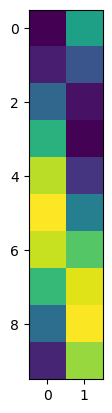

In [42]:
plt.imshow(g.laplacian_eigs.numpy())

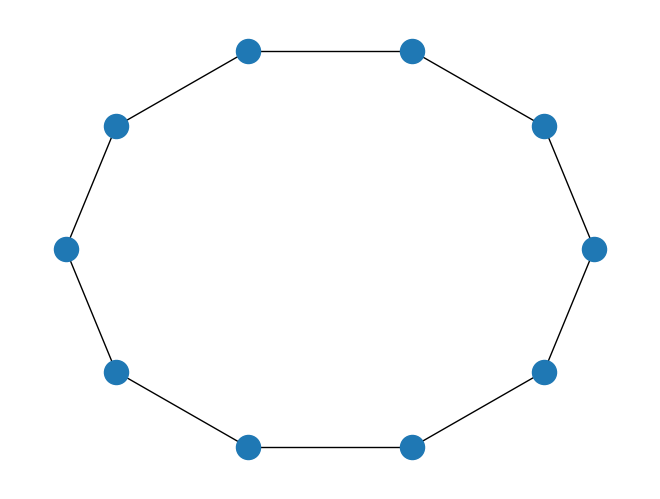

In [43]:
nx.draw_circular(networkx_graphs[0])

In [44]:
# Features
#batch.x = torch.ones(batch.num_nodes, dtype=torch.long)
batch.x = torch.range(0, batch.num_nodes-1, dtype=torch.long)

/tmp/ipykernel_90229/131016083.py:3: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  batch.x = torch.range(0, batch.num_nodes-1, dtype=torch.long)


In [45]:
model = GraphTransformer(batch.num_nodes, 16, 4, 20, 1, 0.0, 0.0, POS_ENCODING_DIM, 'laplacian', 'layer')

In [46]:
out, attention_scores = model(batch, batch.x, batch.laplacian_eigs)

In [47]:
out.shape

torch.Size([145, 16])

In [48]:
attention_scores[0].shape

torch.Size([10, 4, 19, 19])

In [49]:
attention_scores[0][0,2].detach().numpy()[0]

array([5.6051939e-45, 4.1437468e-01, 2.3822074e-44, 1.1210388e-44,
       5.6051939e-44, 6.0255834e-44, 1.2611686e-44, 4.0637655e-44,
       1.8216880e-44, 5.8562529e-01, 2.2420775e-44, 2.2420775e-44,
       2.2420775e-44, 2.2420775e-44, 2.2420775e-44, 2.2420775e-44,
       2.2420775e-44, 2.2420775e-44, 2.2420775e-44], dtype=float32)

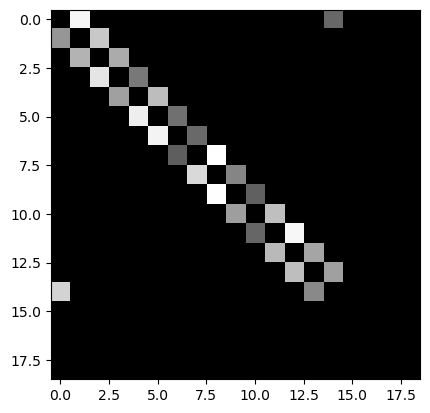

In [50]:
plt.imshow(attention_scores[0][5,0].detach().numpy(), cmap='gray')

In [26]:
torch.zeros(10)*torch.inf
F.softmax(-torch.zeros(10)*torch.inf)

tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [52]:
a = torch.randn(10)*3
F.softmax(a, dim=-1)

tensor([4.3857e-05, 6.3669e-01, 1.1828e-05, 4.5202e-05, 4.9879e-04, 1.3885e-02,
        3.3762e-01, 3.7543e-03, 5.3268e-03, 2.1297e-03])

In [55]:
a[2] = -torch.inf
F.softmax(a, dim=-1)

tensor([4.3858e-05, 6.3670e-01, 0.0000e+00, 4.5203e-05, 4.9880e-04, 1.3885e-02,
        3.3762e-01, 3.7544e-03, 5.3269e-03, 2.1297e-03])

In [60]:
a[2] = -100
F.softmax(a, dim=-1)

tensor([4.3858e-05, 6.3670e-01, 0.0000e+00, 4.5203e-05, 4.9880e-04, 1.3885e-02,
        3.3762e-01, 3.7544e-03, 5.3269e-03, 2.1297e-03])

In [16]:
attention_scores[0][0,2].detach().numpy()

array([[0.10068794, 0.10119697, 0.10124578, 0.10081513, 0.10007394,
        0.0993086 , 0.09880906, 0.09876143, 0.0991833 , 0.0999179 ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.10150456, 0.10044084, 0.09921766, 0.09830014, 0.09802727,
        0.09849824, 0.09954139, 0.10076856, 0.10170913, 0.10199224,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.10227735, 0.09984633, 0.09751504, 0.09614288, 0.09620982,
        0.09769292, 0.1000715 , 0.10246392, 0.10392629, 0.10385397,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.10272919, 0.09965762, 0.09678077, 0.09514558, 0.09530944,
        0.09721774, 0.1002141 , 0.10319301, 0.10496649, 0.10478603,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.   

In [17]:
adj

tensor([[[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[1., 1., 1.,  ..., 1., 0., 0.],
         [1., 1., 1.,  ..., 1., 0., 0.],
         [1., 1., 1.,  ..., 1., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 1., 0., 0.],
         [0., 0., 0., 

In [73]:
g = batch
adj = torch_geometric.utils.to_dense_adj(g.edge_index, g.batch)

adj_mask = (1.0-adj).unsqueeze(1).repeat(1, 8, 1, 1)*(-10000)

adj_mask

tensor([[[[    -0.,     -0.,     -0.,  ..., -10000., -10000., -10000.],
          [    -0.,     -0.,     -0.,  ..., -10000., -10000., -10000.],
          [    -0.,     -0.,     -0.,  ..., -10000., -10000., -10000.],
          ...,
          [-10000., -10000., -10000.,  ..., -10000., -10000., -10000.],
          [-10000., -10000., -10000.,  ..., -10000., -10000., -10000.],
          [-10000., -10000., -10000.,  ..., -10000., -10000., -10000.]],

         [[    -0.,     -0.,     -0.,  ..., -10000., -10000., -10000.],
          [    -0.,     -0.,     -0.,  ..., -10000., -10000., -10000.],
          [    -0.,     -0.,     -0.,  ..., -10000., -10000., -10000.],
          ...,
          [-10000., -10000., -10000.,  ..., -10000., -10000., -10000.],
          [-10000., -10000., -10000.,  ..., -10000., -10000., -10000.],
          [-10000., -10000., -10000.,  ..., -10000., -10000., -10000.]],

         [[    -0.,     -0.,     -0.,  ..., -10000., -10000., -10000.],
          [    -0.,     -0.,  

In [76]:
F.softmax(adj_mask, dim=-1)*padding_mask

tensor([[[[0.1000, 0.1000, 0.1000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1000, 0.1000, 0.1000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1000, 0.1000, 0.1000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.1000, 0.1000, 0.1000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1000, 0.1000, 0.1000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1000, 0.1000, 0.1000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.1000, 0.1000, 0.1000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1000, 0.1000, 0.1000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1000, 0.1000, 0.1000,  ..., 0

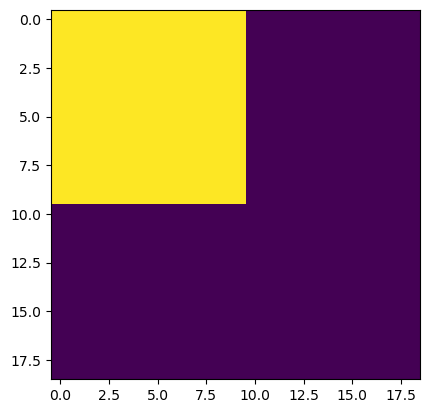

In [66]:
plt.imshow(adj[0])

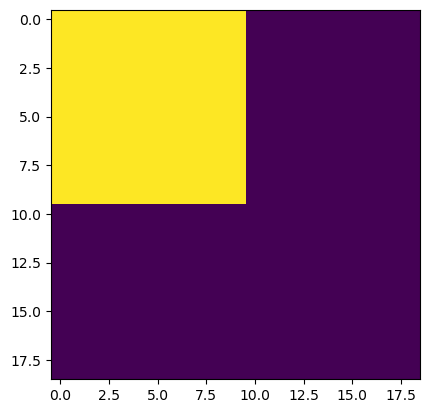

In [74]:
plt.imshow((F.softmax(adj_mask, dim=-1)*padding_mask)[0,0])

In [70]:
x, padding_mask = torch_geometric.utils.to_dense_batch(g.x, g.batch)
padding_mask = padding_mask.unsqueeze(1).repeat(1,8,1).unsqueeze(-1)
padding_mask.shape

torch.Size([10, 8, 19, 1])

In [33]:
attention_mask = torch.zeros(adj_mask.size(), dtype=torch.float)
attention_mask.shape

torch.Size([10, 8, 19, 19])

In [37]:
# Attention mask for addition format
attention_mask = torch.nn.functional._canonical_mask(mask=adj_mask,
                                                            mask_name="attention_mask",
                                                            other_type=None,
                                                            other_name="",
                                                            target_type=torch.float,
                                                            check_other=False,)

attention_mask

tensor([[[[0., 0., 0.,  ..., -inf, -inf, -inf],
          [0., 0., 0.,  ..., -inf, -inf, -inf],
          [0., 0., 0.,  ..., -inf, -inf, -inf],
          ...,
          [-inf, -inf, -inf,  ..., -inf, -inf, -inf],
          [-inf, -inf, -inf,  ..., -inf, -inf, -inf],
          [-inf, -inf, -inf,  ..., -inf, -inf, -inf]],

         [[0., 0., 0.,  ..., -inf, -inf, -inf],
          [0., 0., 0.,  ..., -inf, -inf, -inf],
          [0., 0., 0.,  ..., -inf, -inf, -inf],
          ...,
          [-inf, -inf, -inf,  ..., -inf, -inf, -inf],
          [-inf, -inf, -inf,  ..., -inf, -inf, -inf],
          [-inf, -inf, -inf,  ..., -inf, -inf, -inf]],

         [[0., 0., 0.,  ..., -inf, -inf, -inf],
          [0., 0., 0.,  ..., -inf, -inf, -inf],
          [0., 0., 0.,  ..., -inf, -inf, -inf],
          ...,
          [-inf, -inf, -inf,  ..., -inf, -inf, -inf],
          [-inf, -inf, -inf,  ..., -inf, -inf, -inf],
          [-inf, -inf, -inf,  ..., -inf, -inf, -inf]],

         ...,

         [[0., 0

In [39]:
attention_mask.shape

torch.Size([10, 8, 19, 19])

In [40]:
padding_mask.shape

torch.Size([10, 8, 19])

In [42]:
attention_mask*padding_mask.unsqueeze(-1)

tensor([[[[0., 0., 0.,  ..., -inf, -inf, -inf],
          [0., 0., 0.,  ..., -inf, -inf, -inf],
          [0., 0., 0.,  ..., -inf, -inf, -inf],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[0., 0., 0.,  ..., -inf, -inf, -inf],
          [0., 0., 0.,  ..., -inf, -inf, -inf],
          [0., 0., 0.,  ..., -inf, -inf, -inf],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[0., 0., 0.,  ..., -inf, -inf, -inf],
          [0., 0., 0.,  ..., -inf, -inf, -inf],
          [0., 0., 0.,  ..., -inf, -inf, -inf],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         ...,

         [[0., 0., 0.,  ..., -inf, -inf, -inf],
          [0., 0., 0.,

In [21]:
model = GraphRepresentationGraphTransformer(2,8,1,32,1,0.0,0.0,k=POS_ENCODING_DIM,pos_encoding=None, norm=None, readout='mean')

Accepted values for norm: 'layer' and 'batch'. Proceeding without normalization layers.


In [22]:
model(batch, batch.x)

tensor([[ 0.2884,  2.0394, -1.2443, -0.2292, -0.2319, -0.8444,  0.5057, -0.4165],
        [ 0.3331,  1.9958, -1.1855, -0.2285, -0.2192, -0.8393,  0.5538, -0.3853],
        [ 0.3781,  1.9518, -1.1262, -0.2278, -0.2065, -0.8340,  0.6025, -0.3538],
        [ 0.4236,  1.9073, -1.0663, -0.2271, -0.1936, -0.8288,  0.6515, -0.3220],
        [ 0.4682,  1.8652, -1.0042, -0.2253, -0.1794, -0.8253,  0.7000, -0.2930],
        [ 0.5127,  1.8234, -0.9409, -0.2230, -0.1647, -0.8224,  0.7486, -0.2646],
        [ 0.5576,  1.7813, -0.8771, -0.2208, -0.1498, -0.8195,  0.7976, -0.2360],
        [ 0.6030,  1.7389, -0.8127, -0.2185, -0.1349, -0.8166,  0.8471, -0.2071],
        [ 0.6487,  1.6960, -0.7477, -0.2162, -0.1197, -0.8136,  0.8970, -0.1779],
        [ 0.6938,  1.6515, -0.6831, -0.2151, -0.1017, -0.8085,  0.9475, -0.1480]],
       grad_fn=<DivBackward0>)

In [37]:
C1_batch = Batch.from_data_list([torch_geometric_graphs[0]])
#C1_batch.x = torch.ones(C1_batch.num_nodes, dtype=torch.long)
C1_batch.x = torch.range(0, C1_batch.num_nodes-1, dtype=torch.long)
C1_batch

/tmp/ipykernel_65935/744447651.py:3: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  C1_batch.x = torch.range(0, C1_batch.num_nodes-1, dtype=torch.long)


DataBatch(edge_index=[2, 30], num_nodes=10, laplacian_eigs=[10, 4], wl_encoding=[10], batch=[10], ptr=[2], x=[10])

In [40]:
model = GraphTransformer(10, 16, 4, 20, 1, 0.0, 0.0, POS_ENCODING_DIM, None, 'layer')

In [41]:
model(C1_batch, C1_batch.x, precomputed_eigenvectors=C1_batch.laplacian_eigs)

tensor([[ 0.8744,  0.8175,  0.1311,  2.1191, -0.0109,  0.7796, -0.3331,  0.2649,
         -2.2398, -1.1661, -0.5722,  0.4417, -0.9872, -0.8004,  0.8526, -0.1711],
        [-0.7642,  0.8023,  0.3971,  0.5484, -0.6432,  0.4756, -0.4252, -0.6157,
         -0.8927, -0.9772, -1.1636,  0.8466,  0.0209, -0.7109,  2.9607,  0.1410],
        [ 0.3244,  1.4638,  0.1671,  0.3382, -0.9442,  2.1668, -0.2917,  0.1419,
          0.1705,  1.1821, -2.1135, -0.9452, -0.0990, -0.0895, -0.8597, -0.6119],
        [ 0.1975, -0.5398,  1.4378,  1.1986,  1.9914, -0.1182,  0.4058, -0.3679,
         -0.9690, -1.6570, -0.2837,  1.0925, -1.0096, -1.3405, -0.2532,  0.2153],
        [-0.5597, -0.1875, -1.3227,  1.9313, -0.9928, -0.1840,  0.1064,  1.0283,
         -0.0803, -0.8687,  1.1626,  1.5618,  0.1491, -1.6495,  0.5790, -0.6732],
        [ 0.5058,  0.2113,  1.3642,  0.4414,  0.4104, -0.5587, -0.4222,  0.2186,
         -0.6752, -1.8546, -0.3212,  1.0556,  1.4814, -0.4556,  0.7894, -2.1906],
        [-0.7001,  0.9

In [27]:
C1_batch.x

In [48]:
G1 = nx.empty_graph(6)
nx.add_cycle(G1, [0,1,2])
nx.add_cycle(G1, [3,4,5])

G2 = nx.cycle_graph(6)

# Convert NetworkX graphs to PyTorch Geometric format
torch_geometric_graphs = [transforms(from_networkx(G1)), transforms(from_networkx(G2))]

# Create a batch from the list of graphs
batch = Batch.from_data_list(torch_geometric_graphs)
batch.x = torch.ones(batch.num_nodes, dtype=torch.long)
#batch.x = torch.range(0, batch.num_nodes-1, dtype=torch.long)
batch

DataBatch(edge_index=[2, 36], num_nodes=12, laplacian_eigs=[12, 2], wl_encoding=[12], batch=[12], ptr=[3], x=[12])

In [53]:
model = GraphRepresentationGraphTransformer(2,8,1,32,1,0.0,0.0,k=POS_ENCODING_DIM,pos_encoding='laplacian', norm=None, readout='mean')

Accepted values for norm: 'layer' and 'batch'. Proceeding without normalization layers.


In [54]:
model(batch, batch.x, precomputed_eigenvectors=batch.laplacian_eigs)

tensor([[-0.5123,  0.7471, -1.7702, -0.5361, -0.9280,  1.1038, -0.4557, -0.9933],
        [-0.5932,  0.9244, -1.8894, -0.6089, -0.9578,  0.9086, -0.3349, -1.1334]],
       grad_fn=<DivBackward0>)